## Topic Clustering

In [1]:
# import needed libraries
from bson import json_util
import requests, json, re
import pandas as pd
import matplotlib
import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary
import pyLDAvis.gensim
import os
import random
import numpy as np
import datetime
from nltk import word_tokenize, sent_tokenize, ngrams, pos_tag
from nltk.corpus import stopwords
import gensim, operator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import spatial
from gensim.models import KeyedVectors

### Load data

In [2]:
data = []
with open('./tweets.json', 'r') as f:
    for line in f.readlines():
        data.append(json.loads(line))
print('There are', len(data),'tweets for topic clustering.')
print('Here is an example of the tweet:')
print(data[0])

There are 5071 tweets for topic clustering.
Here is an example of the tweet:
{'url': 'https://twitter.com/AshleyDHeck1/status/1244776214222553088', 'text': 'Ya know how everyone kept saying "hold my beer", as a way to show things could most definitely get worse in situations? ... Well they named this stupid virus after a beer. 🤦🍷🍷🤷😂 #randomthoughts #coronavirus #wth #COVID19 #corona #lol #imlosingit https://t.co/gZJIKJc8md', 'date': 1585612750000, 'tweet_id': 1244776214222553088, 'user_name': 'AshleyDHeck1', 'cleaned_text': 'Ya know how everyone kept saying hold my beer as a way to show things could most definitely get worse in situations  Well they named this stupid virus after a beer  randomthoughts coronavirus wth COVID corona lol imlosingit '}


### Save data to a data frame

In [3]:
df = pd.DataFrame(data[0:])
df = df.iloc[: , 0:6]
df.columns =["url","text","date","tweet_id","user_name","cleaned_text"]
df['date']=df['date'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d'))
df.head()

,url,text,date,tweet_id,user_name,cleaned_text
0,https://twitter.com/AshleyDHeck1/status/124477...,"Ya know how everyone kept saying ""hold my beer...",2020-03-30,1244776214222553088,AshleyDHeck1,Ya know how everyone kept saying hold my beer ...
1,https://twitter.com/CffeeAndSarcasm/status/124...,AA is going to need a bouncer when this is ove...,2020-03-30,1244758836516397056,CffeeAndSarcasm,AA is going to need a bouncer when this is ove...
2,https://twitter.com/KarinBrauns/status/1244757...,Don’t drown in your own thoughts.. Stay close ...,2020-03-30,1244757544431751171,KarinBrauns,Don’t drown in your own thoughts Stay close at...
3,https://twitter.com/AspenBrewingCo/status/1244...,Mix it up this week with a delicious pizza and...,2020-03-30,1244753120669958144,AspenBrewingCo,Mix it up this week with a delicious pizza and...
4,https://twitter.com/Didanmeg/status/1244748406...,The only beer we will be drinking until this w...,2020-03-30,1244748406435852289,Didanmeg,The only beer we will be drinking until this w...


* The trend of tweets

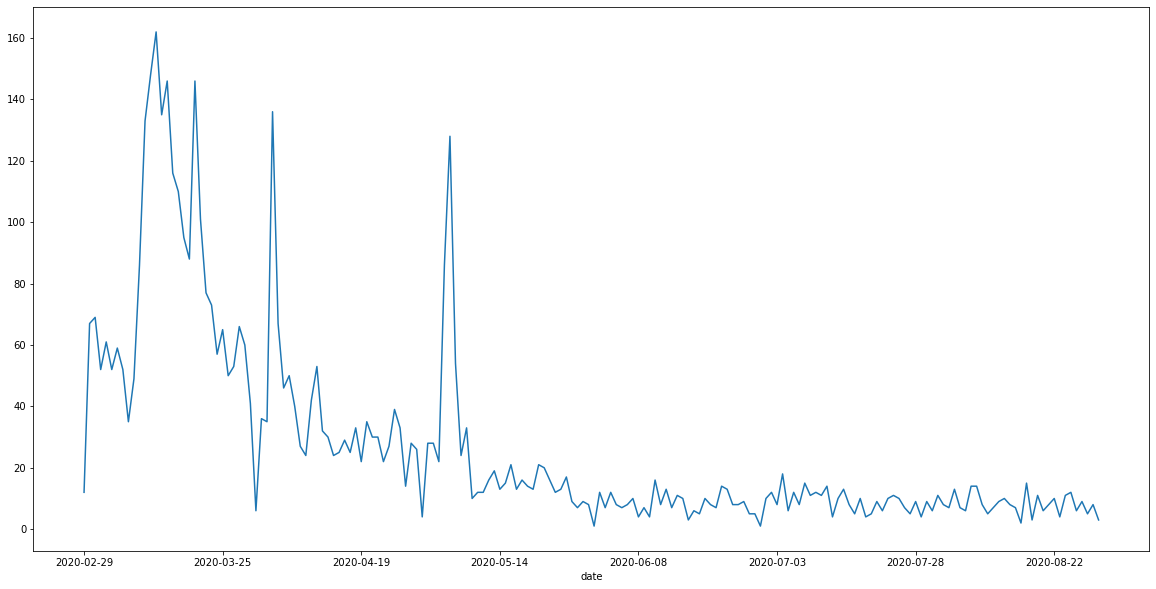

In [4]:
no_of_tweets = df.groupby(['date'])
tweets_over_time=no_of_tweets.count().drop(columns=['url', 'text','user_name','cleaned_text'])
ts = pd.Series(tweets_over_time['tweet_id'],index=tweets_over_time.index)
plt.figure(figsize=(20,10))
ts.plot()

### LDA model

In [5]:
# Convert tweet to lowercase
text = []
for item in df['cleaned_text']:
    text.append(item.lower())

In [6]:
# Remove stopwords
word=[]
for t in text:
    word.append(word_tokenize(t))
stop_words = set(stopwords.words('english'))
non_stop_word = []
for s in word:
    sent = []
    for w in s:
        if w not in stop_words:
            sent.append(w)
    non_stop_word.append(sent)

In [7]:
tweets = pd.Series(non_stop_word)

In [8]:
dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=90)
corpora = [dictionary.doc2bow(doc) for doc in tweets]

lda_model = ldamodel.LdaModel(corpora, num_topics=6, id2word = dictionary, passes=40, random_state=4)

In [21]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpora, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.047169 -0.063469       1        1  24.049944
5     -0.139312 -0.139897       2        1  19.156610
2     -0.163437 -0.037910       3        1  19.048662
0      0.254900 -0.059986       4        1  16.160795
1      0.151720  0.017722       5        1  14.678576
4     -0.056702  0.283540       6        1   6.905409, topic_info=         Term         Freq        Total Category  logprob  loglift
0        beer  3211.000000  3211.000000  Default  30.0000  30.0000
21    alcohol  1364.000000  1364.000000  Default  29.0000  29.0000
178      hand   287.000000   287.000000  Default  28.0000  28.0000
179     hands   283.000000   283.000000  Default  27.0000  27.0000
35          ’   853.000000   853.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
44   drinking    43.235523   245.244720   Topic6  -4.4701   0.9373
145     beers    38.207447   210.015656   Topic6  -4.5938   0.9687
209      long    31.364672    57.613319   Topic6  -4.7911   2.0648
21    alcohol    36.658817  1364.692017   Topic6  -4.6352  -0.9442
456     sales    31.516981   130.545853   Topic6  -4.7863   1.2517

[352 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
537       1  0.962883  actually
21        1  0.266727   alcohol
21        4  0.203709   alcohol
21        5  0.501945   alcohol
21        6  0.027112   alcohol
...     ...       ...       ...
35        2  0.485972         ’
35        3  0.154574         ’
109       1  0.996281         “
251       1  0.990161         ”
869       1  0.987095         •

[451 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 1, 2, 5])

In [9]:
# LDA result
output = []
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 15)
    topk_words = [ w for w, _ in topk ]
    output.append(topk_words)
    print('{}: {}'.format(topic_id, ' '.join(topk_words)))

0: corona covid coronavirus hand hands alcohol sanitizer virus wash use soap water alcoholbased based china
1: corona alcohol covid lockdown coronavirus liquor amp india pandemic people due virus government alcoholic socialdistancing
2: corona beer coronavirus virus ’ mexico one beers summer bar would production get free amp
3: corona beer covid coronavirus alcohol ’ people virus drinking “ ” know get one like
4: corona beer mexican covid virus hold modelo us de name amp pandemic named new mayo
5: corona beer ’ day coronabeer coronavirus covid quarantine drink home happy love time cincodemayo cheers


In [10]:
# store result in a dataframe
dictionary.filter_extremes(no_below=10, no_above=90)
corpora = [dictionary.doc2bow(doc) for doc in tweets]
# show which topic cluster each article belongs to
topics = []
for i in range(len(tweets)):
    topic = lda_model.get_document_topics(corpora[i])
    topics.append(topic)

# transfer topics into a list of dictionaries
topics_dic = []
for topic in topics:
    dic = {}
    for item in topic:
        dic[item[0]] = item[1]
    topics_dic.append(dic)

topic_cluster = []
for i in range(len(tweets)):
    cluster = max(topics_dic[i], key=topics_dic[i].get)
    l = [data[i]['text'], cluster]
    topic_cluster.append(l)
    
topic_cluster = pd.DataFrame(topic_cluster)
topic_cluster.columns= ['tweet', 'cluster']
topic_cluster.head()

,tweet,cluster
0,"Ya know how everyone kept saying ""hold my beer...",3
1,AA is going to need a bouncer when this is ove...,5
2,Don’t drown in your own thoughts.. Stay close ...,3
3,Mix it up this week with a delicious pizza and...,5
4,The only beer we will be drinking until this w...,3


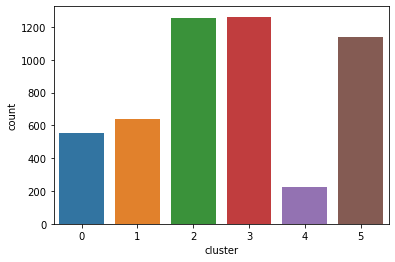

In [11]:
# result visualization
cluster_count = topic_cluster['cluster'].value_counts()
p = sns.countplot(data=topic_cluster, x = 'cluster')
plt.show()

### Implementation of topic classifier

In [12]:
# Load the pre-trained Word2Vec model
model_path = '/Users/feiyid/desktop/'
def load_wordvec_model(modelName, modelFile, flagBin):
    print('Loading ' + modelName + ' model...')
    model = KeyedVectors.load_word2vec_format(model_path + modelFile, binary=flagBin)
    print('Finished loading ' + modelName + ' model...')
    return model

model_word2vec = load_wordvec_model('Word2Vec', 'GoogleNews-vectors-negative300.bin.gz', True)

Loading Word2Vec model...
Finished loading Word2Vec model...


In [13]:
# Define taxonomy
topic_taxonomy = {
    "Celebration Beer":
    {
        "celebration day": "corona beer drink Cinco de Mayo"
    },
    "Corona Virus":
    {
        "quarantine": "corona covid beer coronavirus quarantine virus sales pandemic stayhome staysafe socialdistancing"
    },
    "Disinfect":
    {
        "sanitize": "corona alcohol covid hand hands sanitizer coronavirus wash soap water use virus alcoholbased mask amp clean handsanitizer sanitizers health"
    },
    "Corona drinking":
    {
        "alcohol drinking":  "alcohol corona lockdown covid liquor people amp drinking india us money government shops wine"
    },
    "Mexican":
    {
        "Mexican beer":  "corona beer covid coronavirus virus people amp mexican"
    },
    "Sentiment":
    {
        "joy":  "corona beer covid coronavirus love happy like china new memes follow wuhan viruscorona"
    },
}

In [14]:
# Build functions
# function checks whether the input words are present in the vocabulary for the model
def vocab_check(vectors, words):
    
    output = list()
    for word in words:
        if word in vectors.vocab:
            output.append(word.strip())
            
    return output

# Calculate semantic similarity of a pair of strings
def calc_similarity(input1, input2, vectors):
    s1words = set(vocab_check(vectors, input1.split()))
    s2words = set(vocab_check(vectors, input2.split()))
    
    output = vectors.n_similarity(s1words, s2words)
    return output

# Classify topics (run similarity of input string against taxonomy, sort and return top 3 result)
def classify_topics(input, vectors):
    feed_score = dict()
    for key, value in topic_taxonomy.items():
        max_value_score = dict()
        for label, keywords in value.items():
            max_value_score[label] = 0
            topic = (key + ' ' + keywords).strip()
            max_value_score[label] += float(calc_similarity(input, topic, vectors))
            
        sorted_max_score = sorted(max_value_score.items(), key=operator.itemgetter(1), reverse=True)[0]
        feed_score[sorted_max_score[0]] = sorted_max_score[1]
    return sorted(feed_score.items(), key=operator.itemgetter(1), reverse=True)[:3]

* Topic Similarity

In [15]:
# calculate the topic similarity for each article and choose the best one
topic_similarity = []

tweet = []
for item in df['cleaned_text']:
    text = item.split("#")
    tweet.append(item)

for i in range(len(tweet)):
    title = tweet[i]
    try:
        output = classify_topics(title, model_word2vec)
    except:
        output = [["None", 0]]
    topic = list(output[0])
    topic.append(title)
    topic_similarity.append(topic)
    
# build the data frame
Classifier = pd.DataFrame(topic_similarity, columns=['topic', 'similarity', 'tweet']) 
Classifier.head()

,topic,similarity,tweet
0,joy,0.663286,Ya know how everyone kept saying hold my beer ...
1,alcohol drinking,0.625928,AA is going to need a bouncer when this is ove...
2,joy,0.696251,Don’t drown in your own thoughts Stay close at...
3,joy,0.638301,Mix it up this week with a delicious pizza and...
4,alcohol drinking,0.564316,The only beer we will be drinking until this w...


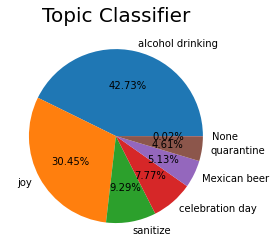

In [16]:
# Visualization
topic_count = Classifier['topic'].value_counts()
plt.pie(topic_count.values,
        labels=topic_count.index,
        autopct='%1.2f%%')
plt.title('Topic Classifier', fontsize=20)
plt.show()

* Topic Trend

In [17]:
Classifier['date'] = df['date']
classifier_plot = Classifier[Classifier['topic'] != 'None']
classifier_plot.head()

,topic,similarity,tweet,date
0,joy,0.663286,Ya know how everyone kept saying hold my beer ...,2020-03-30
1,alcohol drinking,0.625928,AA is going to need a bouncer when this is ove...,2020-03-30
2,joy,0.696251,Don’t drown in your own thoughts Stay close at...,2020-03-30
3,joy,0.638301,Mix it up this week with a delicious pizza and...,2020-03-30
4,alcohol drinking,0.564316,The only beer we will be drinking until this w...,2020-03-30


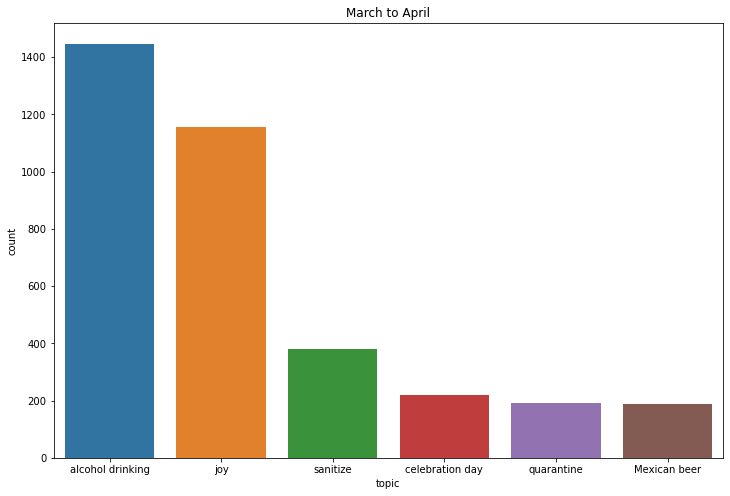

In [18]:
mar2apr = classifier_plot[classifier_plot['date'] < "2020-05-01"]
plt.figure(figsize=(12,8))
p = sns.countplot(data=mar2apr, x = 'topic', order = mar2apr['topic'].value_counts().index)
plt.title('March to April')
plt.show()

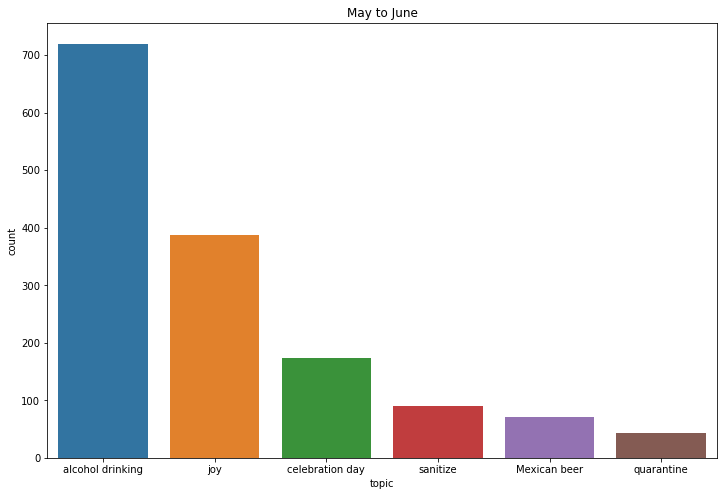

In [19]:
may2june = classifier_plot[classifier_plot['date'] < "2020-07-01"]
may2june = classifier_plot[classifier_plot['date'] >= "2020-05-01"]
plt.figure(figsize=(12,8))
p = sns.countplot(data=may2june, x = 'topic',order = may2june['topic'].value_counts().index)
plt.title('May to June')
plt.show()

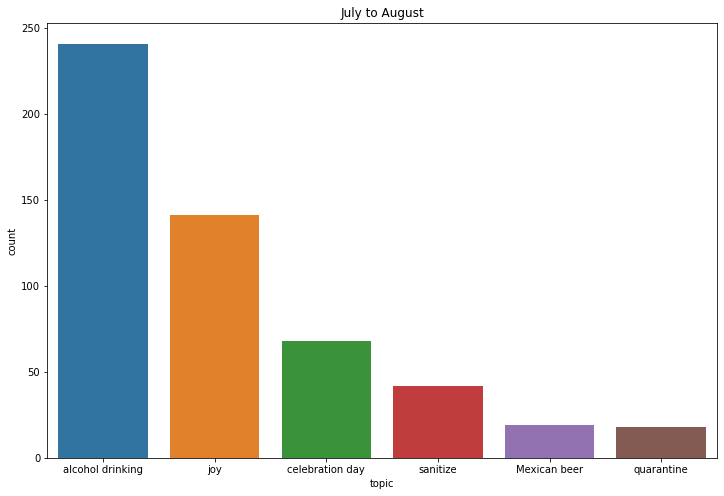

In [20]:
july2aug = classifier_plot[classifier_plot['date'] >= "2020-07-01"]
plt.figure(figsize=(12,8))
p = sns.countplot(data=july2aug, x = 'topic',order = july2aug['topic'].value_counts().index)
plt.title('July to August')
plt.show()